## Transfer Learning - DenseNet201 Model with Image Augmentation

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

import pandas as pd
from PIL import Image
from tqdm import tqdm

import shutil

from itertools import cycle

# ANN
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

from tensorflow.keras.applications.densenet import preprocess_input as prepro_input_dn201
import keras_tuner
import keras_cv

from tensorflow.keras.layers import TFSMLayer

# Scikit-Learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

s:\Repos\drivendata-Conser-vision-Image-Classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%run functions.py

In [4]:
X_train = pd.read_csv("data/X_train.csv")
y_train = pd.read_csv("data/y_train.csv")
X_val = pd.read_csv("data/X_val.csv")
y_val = pd.read_csv("data/y_val.csv")

### Loading the model

In [ ]:
densenet_base = keras.applications.DenseNet201(weights='imagenet', include_top = False, input_shape = (224, 224, 3))

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Location of downloaded pre-trained models

!ls -sh ~/.keras/models/*.h5

72M /c/Users/Flatko/.keras/models/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5


In [ ]:
densenet_base.summary()

Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 18,092,928 (69.02 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [ ]:
for layers in densenet_base.layers[:]:
    layers.trainable = False

### Image Augmentation

Apart from applying different weights to under-represented classes, there are a number of additional techniques which can be leveraged to balance out the distribution among species.

* Undersampling is a technique based around removing images from the dataset until the distribution of classes is equalized.
* Likewise, oversampling is almost the exact opposite of undersampling, except it randomly duplicates the underrepresented classes until there is a balance.
* In this case, a technique called Image Augmentation is used. Rather than introducing duplicates to the data, the process augments the images in some way, replacing the original image. Examples include shifting of images in any direction, zoom in or out, rotating or flipping. While this does not necessarily increase the number of data points, it does introduce "new", augmented images randomly. The model sees these examples and is able to learn more robust features, ultimately leading to better generalizability of the model.

Image augmentation techniques also have additional benefits other than balancing out the class distributions. Because the animals in the invidiual images are not always in the center of the picture, but sometimes appear too far to the left, or are simply too close to the camera, image transformations help level the playing field, making it easier for the model to recognize the different variations of animals that exist in the images.

The image augmentation process involves the following transformations:

* Rotation
* Shearing
* Shifts along the width and height
* Zooming in and out
* Different brightness levels
* Horizontal flip

### Loading images

In [ ]:
train = keras.utils.image_dataset_from_directory(directory = "data/train",
                                               batch_size = 64,
                                               image_size = (224,224))

val = keras.utils.image_dataset_from_directory(directory = "data/valid",
                                               batch_size = 64,
                                               image_size = (224,224))

# Creating a list of augmentation layers

augmentation_layers = [
    prepro_input_dn201,
    #tf.keras.layers.RandomRotation(factor = 0.3, fill_mode = "nearest"),
    #tf.keras.layers.RandomTranslation(height_factor = 0.2, width_factor = 0.2, fill_mode = "nearest"),
    #keras_cv.layers.RandomShear(x_factor = 0.2, fill_mode = "nearest"),
    #tf.keras.layers.RandomZoom(height_factor = (-0.2, 0.2), fill_mode = "nearest"),
    #tf.keras.layers.RandomBrightness(factor = 0.5, value_range = [0, 1]),
    #keras_cv.layers.RandomSaturation(factor = (0.4,0.6)),
    #tf.keras.layers.RandomFlip("horizontal")
    ]

# Augmentation function to be applied to each image
def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_densenet_augmented = train.map(lambda x, y: (data_augmentation(x), tf.one_hot(y, depth = 8)))
val_densenet_augmented = val.map(lambda x, y: (prepro_input_dn201(x), tf.one_hot(y, depth = 8)))

train_densenet_augmented = train_densenet_augmented.prefetch(buffer_size=tf.data.AUTOTUNE).cache()
val_densenet_augmented = val_densenet_augmented.prefetch(buffer_size=tf.data.AUTOTUNE).cache()


Found 12616 files belonging to 8 classes.
Found 3872 files belonging to 8 classes.


Below is an example of what the transformed and augmented images look like.

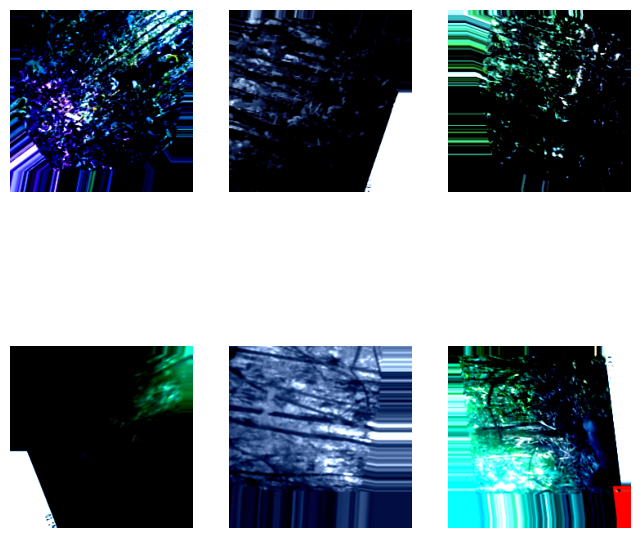

In [ ]:
images, labels = next(iter(train_densenet_augmented))

plt.figure(figsize=(8, 8))

for i in range(6):
    ax = plt.subplot(2,3, i + 1)

    plt.imshow(images[i])
    plt.axis("off")

#### Weighting classes

In [ ]:
class_weights = compute_class_weight(class_weight="balanced", classes = np.array(y_train.columns), y = y_train.idxmax(axis = 1))
dict_weights = dict(zip(y_train.columns, class_weights))

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,0.790476,1.266667,0.912088,0.794058,2.346726,0.960414,0.812887,1.120824


In [ ]:
dict_weights_numbers = {{list(dict_weights.keys())[i]: list(range(8))[i] for i in range(len(list(dict_weights.keys())))}[old_key]: value for old_key, value in dict_weights.items()}

### Creating the model

In [ ]:
class DensenetHypermodel(keras_tuner.HyperModel):

  def build (self, hp = keras_tuner.HyperParameters()):


      K.clear_session()

      model = Sequential()

      # Data Augmentation

      model.add(tf.keras.layers.RandomRotation(factor = 0.4, fill_mode = "nearest"))
      model.add(tf.keras.layers.RandomTranslation(height_factor = 0.2, width_factor = 0.2, fill_mode = "nearest"))
      #model.add(keras_cv.layers.RandomShear(x_factor = 0.2, fill_mode = "nearest"))
      model.add(tf.keras.layers.RandomZoom(height_factor = (-0.3, 0.3), fill_mode = "nearest"))
      #model.add(tf.keras.layers.RandomBrightness(factor = 0.1, value_range = [0, 1]))
      #model.add(keras_cv.layers.RandomSaturation(factor = (0.4,0.6)))
      model.add(tf.keras.layers.RandomFlip("horizontal"))


      model.add(densenet_base)

      model.add(Flatten())
      model.add(BatchNormalization())


      #Layer 1

      model.add(Dense(units = hp.Choice("units_1", [64, 128, 256, 512]),
                      kernel_initializer = hp.Choice("kernel_init", ["uniform", "glorot_uniform", "glorot_normal"]),
                      kernel_regularizer = keras.regularizers.L2(hp.Float("kernel_reg_1", min_value=1e-4, max_value=1e-1, sampling = "log")),
                      name = "dense1"))
      if hp.Boolean("dropout_layer_1"):
        model.add(Dropout(rate = hp.Float("dropout_rate_1", min_value = 0, max_value = 0.5, step = 0.1)))
      model.add(BatchNormalization())
      model.add(Activation(hp.Choice("activation", ["relu","gelu","selu"])))


    # Layer 2

      model.add(Dense(units = hp.Choice("units_2", [64, 128, 256, 512]),
                      kernel_initializer = hp.Choice("kernel_init", ["uniform", "glorot_uniform", "glorot_normal"]),
                      kernel_regularizer = keras.regularizers.L2(hp.Float("kernel_reg_2", min_value=1e-4, max_value=1e-1, sampling = "log")),
                      name = "dense2"))
      if hp.Boolean("dropout_layer_2"):
        model.add(Dropout(rate = hp.Float("dropout_rate_2", min_value = 0, max_value = 0.5, step = 0.1)))
      model.add(BatchNormalization())
      model.add(Activation(hp.Choice("activation", ["relu","gelu","selu"])))


      # Output layer (softmax)
      model.add(Dense(units = 8, activation = "softmax", name = "output"))



      #compiling model

      lr = hp.Float("lr", min_value = 1e-4, max_value = 1e-1, sampling = "log")

      optimizers_dict = {
          "adam":    keras.optimizers.Adam(learning_rate = lr),
          "sgd":     keras.optimizers.SGD(learning_rate = lr, momentum =  hp.Float("momentum", min_value = 0.85, max_value = 0.95)),
          "rmsprop": keras.optimizers.RMSprop(learning_rate = lr)
          }

      hp_optimizers = hp.Choice('optimizer', values=["adam", "sgd", "rmsprop"])


      model.compile(optimizer = optimizers_dict[hp_optimizers], metrics = ["accuracy"],
                    loss = tf.keras.losses.CategoricalCrossentropy())

      return model


  def fit(self, hp, model, *args, **kwargs):
      return model.fit(*args, batch_size = hp.Choice("batch_size", [32, 64, 128, 256]), **kwargs)


In [ ]:
DensenetHypermodel()

The setup below entails the training of 12 different sets of hyperparameters. This results in 12 trials with 12 different accuracy and loss scores. While it's always beneficial to train as many combinations of hyperparameters as possible, there weren't sufficient computational resources to do that.  

In [ ]:
seed = 65

optimize_densenet_augmented = keras_tuner.BayesianOptimization(hypermodel=DensenetHypermodel(),
                                                     objective = "val_accuracy",
                                                     max_trials = 12,
                                                    overwrite = True
                                                     #seed = seed
                                                               )

es = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 4, start_from_epoch = 5, verbose = 1)

In [ ]:
optimize_densenet_augmented.search(train_densenet_augmented, validation_data = val_densenet_augmented, epochs = 20,
                                   callbacks = [es], class_weight = dict_weights_numbers, verbose = 1)

Trial 12 Complete [00h 15m 56s]
val_accuracy: 0.41503098607063293

Best val_accuracy So Far: 0.4176136255264282
Total elapsed time: 02h 37m 27s


In [ ]:
best_hps_densenet_aug = optimize_densenet_augmented.get_best_hyperparameters(num_trials = 3)

Here are the best hyperparameters for the best model.

In [ ]:
[hp.values for hp in best_hps_densenet_aug][0]

{'units_1': 128,
 'kernel_init': 'glorot_uniform',
 'kernel_reg_1': 0.00031183878254060663,
 'dropout_layer_1': True,
 'activation': 'relu',
 'units_2': 128,
 'kernel_reg_2': 0.022720504690483753,
 'dropout_layer_2': False,
 'lr': 0.0004850763857727682,
 'momentum': 0.9368139833425635,
 'optimizer': 'rmsprop',
 'dropout_rate_2': 0.1,
 'batch_size': 128,
 'dropout_rate_1': 0.0}

With a **validation accuracy of only 41%**, the model's results aren't better than those of the model trained on regular, unaugmented data. However, each trial (model) ran for 20 epochs at most. Because the images were transformed quite a bit, the training and validation accuracies and losses were quite bad in the beginning and only started improving further down the line. This is a good development from the standpoint of not overfitting the model, but it means that more epochs (runs through the entire dataset) might be necessary, as the validation accuracy and loss were improving steadily, but slowly. For this reason, the best model is trained anew on 50 epochs.

In [ ]:
# Initializing a list to store the best models
best_models_densenet_aug = []

# Building the models with the top 3 hyperparameters
for hp in best_hps_densenet_aug:
    model = optimize_densenet_augmented.hypermodel.build(hp)
    best_models_densenet_aug.append(model)

In [ ]:
best_model_densenet_aug = best_models_densenet_aug[0]

In [ ]:
es2 = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 8, verbose = 1)

In [ ]:
training_history = {}
training_history["densenet_base_aug"] = best_model_densenet_aug.fit(train_densenet_augmented, validation_data = val_densenet_augmented, callbacks = [es2],
                                                            class_weight = dict_weights_numbers, epochs = 50, batch_size = 128, verbose = 1)

Epoch 1/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 88s 337ms/step - accuracy: 0.3686 - loss: 4.1459 - val_accuracy: 0.3479 - val_loss: 3.1075
Epoch 2/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 60s 305ms/step - accuracy: 0.4885 - loss: 2.5001 - val_accuracy: 0.3329 - val_loss: 2.5746
Epoch 3/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 60s 306ms/step - accuracy: 0.5191 - loss: 1.9476 - val_accuracy: 0.3990 - val_loss: 2.3217
Epoch 4/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 61s 306ms/step - accuracy: 0.5492 - loss: 1.6971 - val_accuracy: 0.4088 - val_loss: 2.1556
Epoch 5/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 61s 306ms/step - accuracy: 0.5515 - loss: 1.5812 - val_accuracy: 0.3908 - val_loss: 2.2014
Epoch 6/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 61s 307ms/step - accuracy: 0.5694 - loss: 1.4754 - val_accuracy: 0.3833 - val_loss: 2.2978
Epoch 7/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 61s 306ms/step - accuracy: 0.5698 - loss: 1.4348 - val_accuracy: 0.3908 - val_loss: 2.2162
Epoch 8/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 61s 307ms/step - accuracy: 0.5787 -

### Predictions and evaluation on the evaluation set

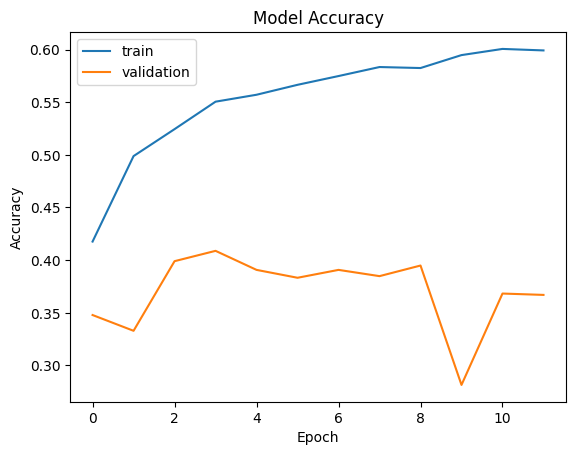

In [ ]:
plot_metric(training_history["densenet_base_aug"])

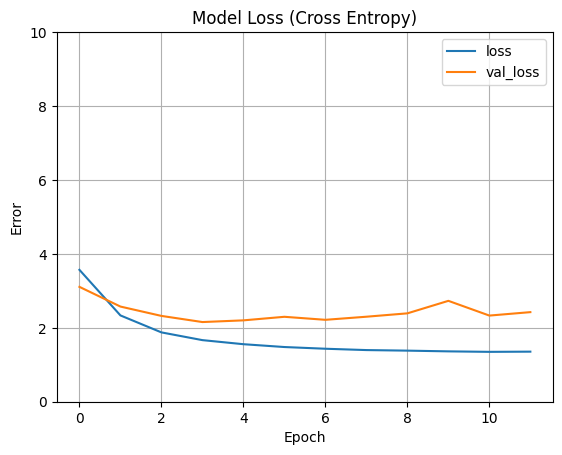

In [ ]:
plot_loss(training_history["densenet_base_aug"])

Again, the difference between the training and validation accuracy is quite high. The validation loss, on the other hand, is not much higher than the training loss after slightly more than 10 rounds (activation of early stopping). Still, at 2.1, the validation loss in general is still relatively high.

Although image augmentation was supposed to prevent overfitting and increase the generalizabiltiy of the model, the concrete techniques applied don't seem to have contributed to that goal in any significant way.

As a preprocessing technique, image augmentation is supposed to have a large impact on model performance and its generalizability. Yet striking the right balance between over- and under-regularizing the model is a tough endeavor. Because of the unavailability of computational resources, no further fine-tuning was possible at this point in time. It is certainly a task of interest in the future.

As with the unaugmented model before, the next section presents the augmented model's prediction on the validation dataset.

In [ ]:
best_model_densenet_aug = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224,224,3)),
    TFSMLayer('densenet_model_aug', call_endpoint='serving_default')
])

In [6]:
#image_paths_train = [f"data/{img_path}" for img_path in X_train["filepath"]]
image_paths_val = [f"data/{img_path}" for img_path in X_val["filepath"]]
#image_paths_test = [f"data/{img_path}" for img_path in test_features["filepath"]]

#train_img = paths_to_tensor(image_paths_train, size_x = 224, size_y = 224)
val_img = paths_to_tensor(image_paths_val, size_x = 224, size_y = 224)
#test_img = paths_to_tensor(image_paths_test, size_x = 224, size_y = 224)

#train_densenet_cv = prepro_input_dn201(train_img)
val_densenet_unshuffled = prepro_input_dn201(val_img)

100%|██████████| 3872/3872 [00:11<00:00, 337.64it/s]


In [ ]:
y_pred_prob_aug = best_model_densenet_aug.predict(val_img, batch_size = 64)

61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step


In [ ]:
label_map = {i: species for i, species in enumerate(y_train.columns)}

In [ ]:
y_pred_aug = decode_predictions(y_pred_prob_aug, label_map)

Similar to the unaugmented model, many more species were predicted to be the **prosimian monkey(31.5%)** than is actually the case, followed by antelope duikers and civet genets.

In [ ]:
y_pred_aug.idxmax(axis = 1).value_counts(normalize = True)

,proportion
monkey_prosimian,0.315857
antelope_duiker,0.191374
civet_genet,0.151860
rodent,0.103306
bird,0.094267
leopard,0.071539
blank,0.037448
hog,0.034349


In [17]:
pd.DataFrame(y_val.set_index("id").idxmax(axis = 1).value_counts(normalize = True))

,proportion
leopard,0.158058
rodent,0.156508
monkey_prosimian,0.142562
blank,0.125000
antelope_duiker,0.123709
civet_genet,0.112862
bird,0.102273
hog,0.079029


As is usually the case, the predictions on the validation set are performed at once, while the validation predictions during training are done on a per-batch-basis and then averaged out. This is the reason why the general accuracy score is lower.

Relatively high **recall rates** can be observed for the **civet genets (63%)** and **prosimian monkeys (73%)**. This means that the model was very good at recognizing these two species as themselves and not something else. However, a lot of other species were, conversely, predicted to be these two animals, which suggests that the model recognized some patterns that were pronounced in images with the civet genets and monkeys and attributed them to images with other species.

On the other hand, not many species were predicted to be a **leopard**, leading to a high **precision rate (85%)**. Considering that leopards have quite specific characteristics, the model did not confuse many species for the leopard.

The recall rate of images with the least represented species in the dataset - **birds and hogs** - are very low (**17% and 22%, respectively**). This means that the model did not do a good job at focusing its attention on those specific cases where these two species appear. 

All in all, the model's general weakness can be seen as a lack of sufficient image augmentation preprocessing.

In [ ]:
print(classification_report(y_pred = y_pred_aug, y_true = y_val, target_names = y_val.columns.tolist()))

                  precision    recall  f1-score   support

 antelope_duiker       0.25      0.39      0.31       479
            bird       0.18      0.17      0.17       396
           blank       0.41      0.12      0.19       484
     civet_genet       0.47      0.63      0.54       437
             hog       0.50      0.22      0.30       306
         leopard       0.85      0.39      0.53       612
monkey_prosimian       0.33      0.73      0.46       552
          rodent       0.27      0.18      0.21       606

       micro avg       0.36      0.36      0.36      3872
       macro avg       0.41      0.35      0.34      3872
    weighted avg       0.42      0.36      0.35      3872
     samples avg       0.36      0.36      0.36      3872



[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

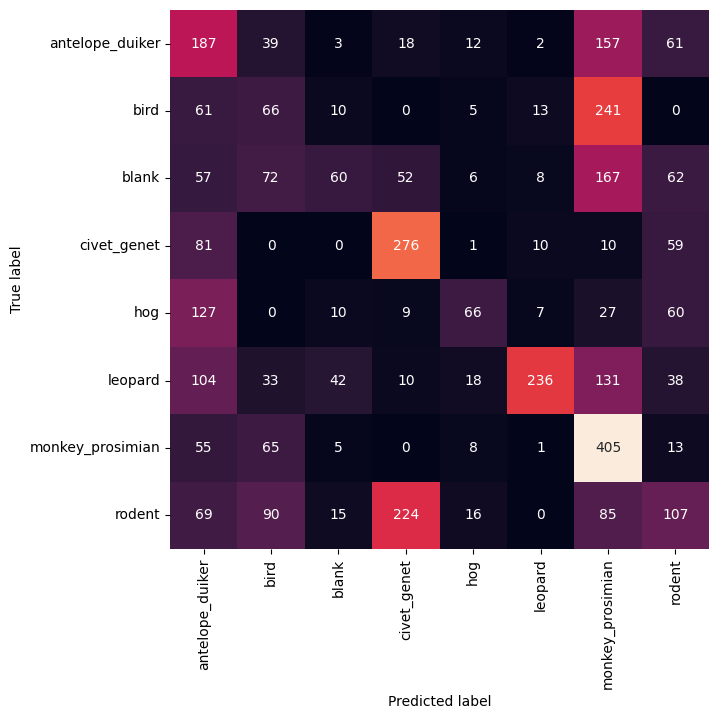

In [ ]:
mat = confusion_matrix(y_pred = y_pred_aug.values.argmax(axis = 1), y_true = y_val.values.argmax(axis = 1))

plt.figure(figsize = (7,7))
map = sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
map.set_xlabel('Predicted label')
map.set_ylabel('True label')
map.set_xticklabels(label_map.values())
map.set_yticklabels(label_map.values())

plt.setp(map.get_xticklabels(), rotation = 90)
plt.setp(map.get_yticklabels(), rotation = 0)


The three species that were classified correctly most frequently - leopards,  prosimian monkeys and civet genets - are also species that appear most often in the dataset. Interestingly, while **antelope duikers** are also well represented in the dataset, the model did not do a great job at detecting this species (**recall at 39%**). Instead, a lot of the images with antelopes were classified as prosimian monkeys. While very different animals, it is possible that they appear at similar times of the day and in similar settings, which is why the model frequently identified antelopes as monkeys. This suggests that the model did not focus sufficiently on the characteristics of the species itself, but more on its surroundings.

**ROC Curve and Area Under Curve (AUC) score**

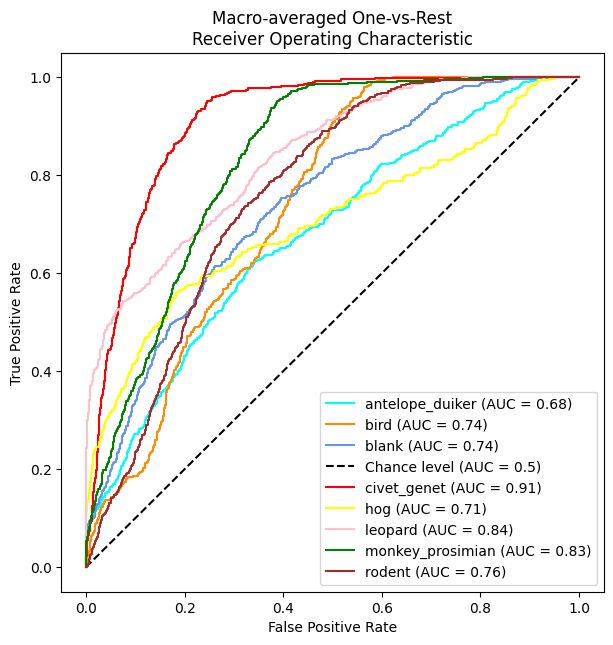

In [ ]:
roc_curve_total(y_true = y_val, y_pred = pd.DataFrame(y_pred_prob_aug), label_map = label_map)

The **civet genet, prosimian monkeys and leopard** have the highest AUC scores. This is reflected in the shape of their ROC curves as well as the high recall and precision and moderately high F1-scores.

Because it has learned some clear patterns from certain images, the model can be said to perform well with the following species:

* Civet genets (**F1-Score: 0.54**)
* Prosimian monkeys (**F1-Score: 0.46**)
* Leopards (**F1-Score: 0.53**)

</br>

Unforunately, for all the other species, the model performs rather poorly. One of the reasons might be the fact that some of the species are small in comparison and/or only appear at night.

Creating better preprocessed images via image augmentation techniques would certainly introduce more diversity into the dataset and allow the model to look out for patterns specific to each species, rather than focusing on other aspects of the image.

In the future, better image preprocessing should be applied to produce a model that is much better at identifying diverse types of species in a forest setting.

Finally, here are some examples of the predicted images by the model.

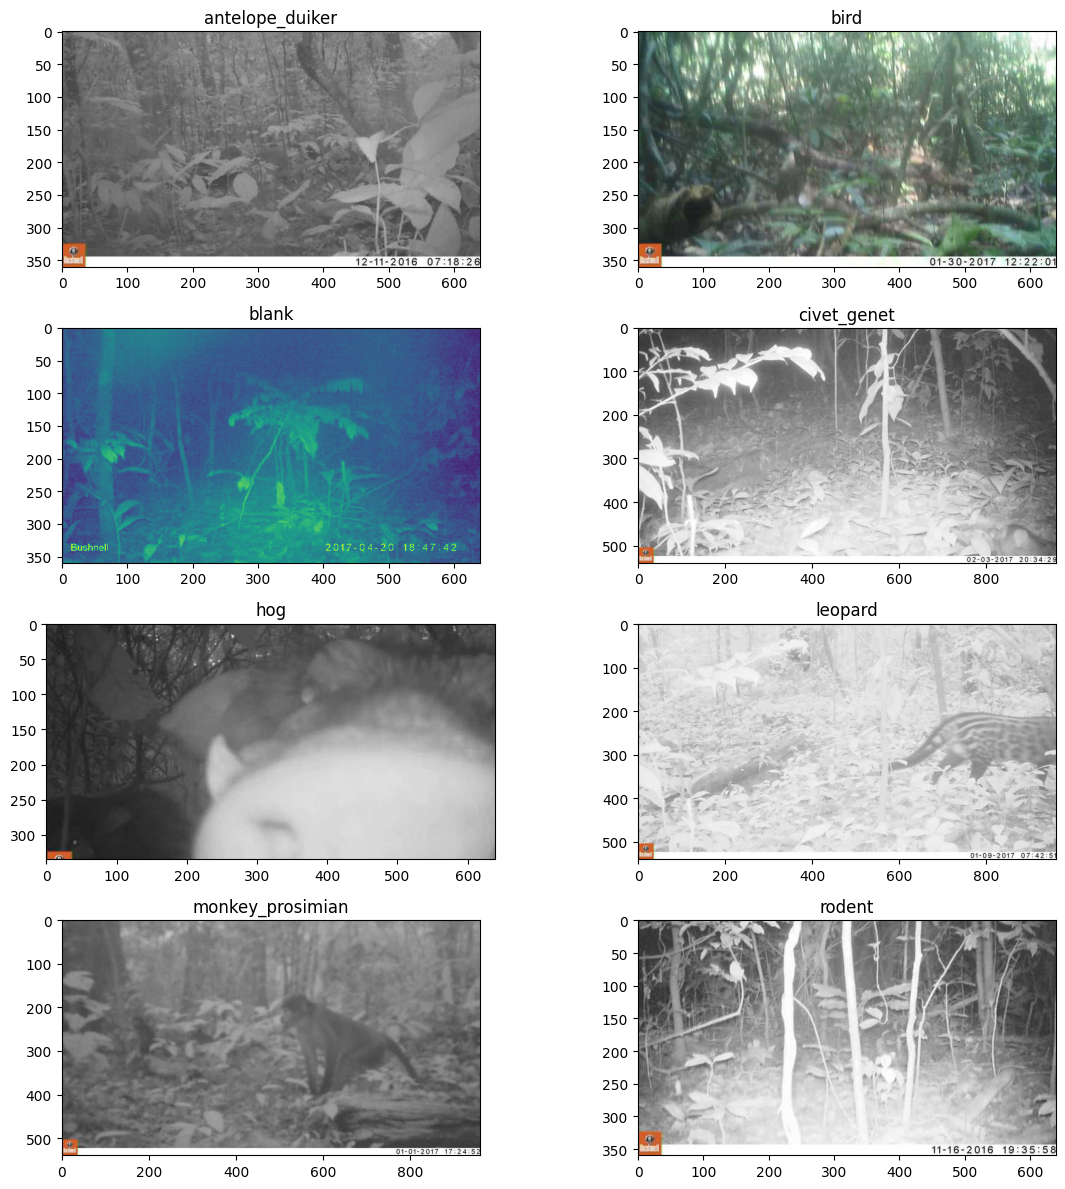

In [ ]:
fig, axes = plt.subplots(4, 2, figsize = (12,12))
axes = axes.flatten()

for i, species in enumerate(train_labels.columns):
    photo_id = y_pred_aug.set_index(y_val.index)[y_pred_aug.set_index(y_val.index)[species] == 1].sample(1).index[0]

    img_path = "data/" + train_features.loc[photo_id].filepath
    img = mpimg.imread(img_path)

    axes[i].imshow(img)
    axes[i].set_title(species)

plt.tight_layout()
plt.show()


**Saving the model**

In [ ]:
!mkdir -p saved_model
best_model_densenet_aug.export('saved_model/densenet_aug')

Saved artifact at 'saved_model/densenet_aug'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  137886442980448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137892548497952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137893684923376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137891610275056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137894421552768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137894421553120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137894421556816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137894421555056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137894421546256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137894421695296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137894